   Unnamed: 0     TV  Radio  Newspaper  Sales
0           1  230.1   37.8       69.2   22.1
1           2   44.5   39.3       45.1   10.4
2           3   17.2   45.9       69.3    9.3
3           4  151.5   41.3       58.5   18.5
4           5  180.8   10.8       58.4   12.9
Closed-form θ: [ 2.93888937e+00  4.57646455e-02  1.88530017e-01 -1.03749304e-03]
GD θ: [nan nan nan nan]


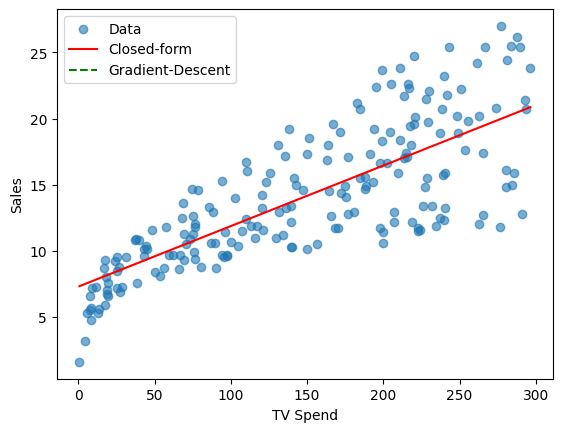

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1)URL
url = "https://raw.githubusercontent.com/justmarkham/scikit-learn-videos/master/data/Advertising.csv"
df  = pd.read_csv(url)
df.to_csv('Advertising.csv')
print(df.head())

# 2)Extract features & target
X_raw = df[['TV', 'Radio', 'Newspaper']].values
y     = df['Sales'].values

# 3)Add bias column of 1s → X
m, n  = X_raw.shape
X     = np.c_[np.ones((m,1)), X_raw]             

# 4)Closed-form solution
theta_closed = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print("Closed-form θ:", theta_closed)

# 5)Batch gradient descent
def gradient_descent(X, y, lr=0.01, n_iters=2000):
    m, n = X.shape
    theta = np.random.randn(n)
    for i in range(n_iters):
        grads = (1/m) * X.T.dot(X.dot(theta) - y)
        theta -= lr * grads
    return theta

theta_gd = gradient_descent(X, y)
print("GD θ:", theta_gd)

# 6)Quick plot (TV spend vs sales) to sanity-check
plt.scatter(df['TV'], y, alpha=0.6, label="Data")
x_line = np.linspace(df['TV'].min(), df['TV'].max(), 100)
X_line = np.c_[np.ones((100,1)), x_line, 
               np.full_like(x_line, df['Radio'].mean()), 
               np.full_like(x_line, df['Newspaper'].mean())]

plt.plot(x_line, X_line.dot(theta_closed), "r-", label="Closed-form")
plt.plot(x_line, X_line.dot(theta_gd),     "g--", label="Gradient-Descent")
plt.xlabel("TV Spend"); plt.ylabel("Sales"); plt.legend()
plt.show()


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1) Load & prepare the Advertising data
url    = "https://raw.githubusercontent.com/justmarkham/scikit-learn-videos/master/data/Advertising.csv"
df     = pd.read_csv(url)
X_raw  = df[['TV', 'Radio', 'Newspaper']].values
y      = df['Sales'].values

# 2) Standardize features (important for fair lr comparison)
scaler = StandardScaler().fit(X_raw)
X_s    = scaler.transform(X_raw)

# 3) Add bias column
m, _ = X_s.shape
X = np.c_[np.ones((m,1)), X_s]

# 4) Define gradient-descent and a loss function
def gradient_descent(X, y, lr, n_iters=1000):
    m, n = X.shape
    theta = np.zeros(n)
    for _ in range(n_iters):
        grad = (1/m) * X.T.dot(X.dot(theta) - y)
        theta -= lr * grad
    return theta

def mse_loss(X, y, theta):
    errs = X.dot(theta) - y
    return (errs**2).mean() / 2

# 5) Sweep over learning rates
lrs = [1e-4, 1e-3, 1e-2, 1e-1, 1]
results = []
for lr in lrs:
    θ = gradient_descent(X, y, lr=lr, n_iters=2000)
    loss = mse_loss(X, y, θ)
    results.append((lr, loss))
    print(f"lr={lr:.4f} → final loss={loss:.4f}")

# 6) Pick the best lr and retrain
best_lr, best_loss = min(results, key=lambda x: x[1])
print(f"\nBest learning rate: {best_lr:.4f} with loss {best_loss:.4f}")

θ_best = gradient_descent(X, y, lr=best_lr, n_iters=5000)
print("Parameters with best lr:", θ_best)

# 7) (Optional) Unscale weights to original feature space
w_scaled = θ_best[1:] / scaler.scale_
b_scaled = θ_best[0] - np.dot(θ_best[1:], scaler.mean_/scaler.scale_)
θ_original = np.r_[b_scaled, w_scaled]
print("Approx θ on original data scale:", θ_original)


lr=0.0001 → final loss=75.1244
lr=0.0010 → final loss=3.4205
lr=0.0100 → final loss=1.3921
lr=0.1000 → final loss=1.3921
lr=1.0000 → final loss=1.3921

Best learning rate: 0.1000 with loss 1.3921
Parameters with best lr: [14.0225      3.91925365  2.79206274 -0.02253861]
Approx θ on original data scale: [ 2.93888937e+00  4.57646455e-02  1.88530017e-01 -1.03749304e-03]


   NumPregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0               6      148             72             35        0  33.6   
1               1       85             66             29        0  26.6   
2               8      183             64              0        0  23.3   
3               1       89             66             23       94  28.1   
4               0      137             40             35      168  43.1   

   DiabetesPedigree  Age  Outcome  
0             0.627   50        1  
1             0.351   31        0  
2             0.672   32        1  
3             0.167   21        0  
4             2.288   33        1  
Iter    0 – Loss: 0.6800
Iter  500 – Loss: 0.4662
Iter 1000 – Loss: 0.4662
Iter 1500 – Loss: 0.4662
Learned θ: [-0.88066458  0.38049482  1.16607088 -0.20482788  0.06949952 -0.13707401
  0.72737274  0.25931544  0.18187626]
Validation Accuracy: 0.714, ROC-AUC: 0.824


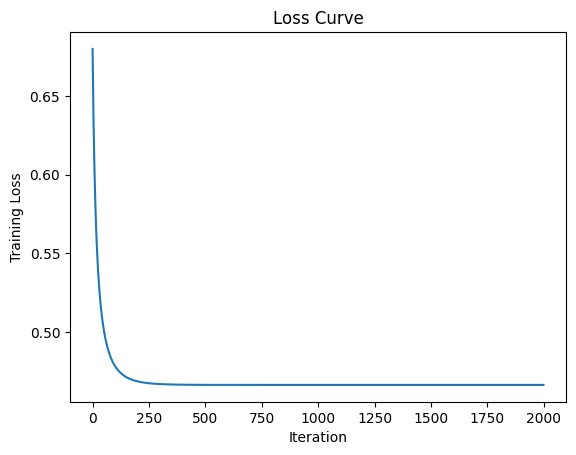

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

# 1) Load the Pima Indians Diabetes dataset from a raw GitHub URL
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
col_names = [
    "NumPregnancies", "Glucose", "BloodPressure", "SkinThickness",
    "Insulin", "BMI", "DiabetesPedigree", "Age", "Outcome"
]
df = pd.read_csv(url, header=None, names=col_names)
print(df.head())
#   NumPregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
#0               6      148             72             35        0  33.6   
#1               1       85             66             29        0  26.6   
#…

# 2) Split into features X and binary target y
X_raw = df.drop("Outcome", axis=1).values
y     = df["Outcome"].values

# 3) Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, stratify=y
)

# 4) Standardize features, then add bias (intercept) column
scaler    = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)

m_train   = X_train_s.shape[0]
m_val     = X_val_s.shape[0]
X_train_b = np.c_[np.ones((m_train,1)), X_train_s]
X_val_b   = np.c_[np.ones((m_val,1)),   X_val_s]

# 5) Define sigmoid, loss, gradient, and predict functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(theta, X, y):
    m = len(y)
    h = sigmoid(X.dot(theta))
    eps = 1e-8
    return - (y*np.log(h+eps) + (1-y)*np.log(1-h+eps)).mean()

def compute_gradient(theta, X, y):
    m = len(y)
    h = sigmoid(X.dot(theta))
    return (X.T.dot(h - y)) / m

def predict(theta, X, threshold=0.5):
    return (sigmoid(X.dot(theta)) >= threshold).astype(int)

# 6) Train with full-batch gradient descent
def train_logistic(X, y, lr=0.1, n_iters=2000):
    theta = np.zeros(X.shape[1])
    for i in range(n_iters):
        grad = compute_gradient(theta, X, y)
        theta -= lr * grad
        if i % 500 == 0:
            print(f"Iter {i:4d} – Loss: {compute_loss(theta, X, y):.4f}")
    return theta

theta = train_logistic(X_train_b, y_train, lr=0.1, n_iters=2000)
print("Learned θ:", theta)

# 7) Evaluate on validation set
y_val_pred = predict(theta, X_val_b)
val_acc    = accuracy_score(y_val, y_val_pred)
val_auc    = roc_auc_score(y_val, sigmoid(X_val_b.dot(theta)))
print(f"Validation Accuracy: {val_acc:.3f}, ROC-AUC: {val_auc:.3f}")

# 8) (Optional) Visualize convergence of loss
loss_history = []
theta_tmp = np.zeros(X_train_b.shape[1])
for i in range(2000):
    theta_tmp -= 0.1 * compute_gradient(theta_tmp, X_train_b, y_train)
    loss_history.append(compute_loss(theta_tmp, X_train_b, y_train))
plt.plot(loss_history)
plt.xlabel("Iteration"); plt.ylabel("Training Loss")
plt.title("Loss Curve"); plt.show()
